In [1]:
import json
from utils.all import *

# Allows interactive plotting
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6, 7, 8, 9, 10, 11], preprocess=True)

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json', '../annotated/batch_7_anton.json', '../annotated/batch_7_ayush.json', '../annotated/batch_7_kelly.json', '../annotated/batch_7_rachel.json', '../annotated/batch_7_vinayak.json', '../annotated/batch_7_vishnesh.json', '../annotated/batch_8_anton.json', '../annotated/batch_8_ayush.json', '../annotated/batch_8_kelly.json', '../annotated/batch_8_rachel.json', '../annotated/batch_8_vinayak.json', '../annotated/batch_8_vishnesh.json', '../annotated/batch_9_ayush.json', '../annotated/batch_9_kelly.json', '../annotated/batch_9_rachel.json', '../annotated/

In [2]:
# Get the percentile of a score among some systems
get_percentile(data, 14.56)['all']

{'new-wiki-1/T5-3B': 49.45054945054945,
 'new-wiki-1/T5-11B': 62.637362637362635,
 'new-wiki-1/Human 1 Writing': 12.982456140350877,
 'new-wiki-1/Muss': 46.996466431095406,
 'new-wiki-1/Human 2 Writing': 11.702127659574469,
 'new-wiki-1/GPT-3-zero-shot': 19.696969696969695,
 'new-wiki-1/GPT-3-few-shot': 18.46153846153846}

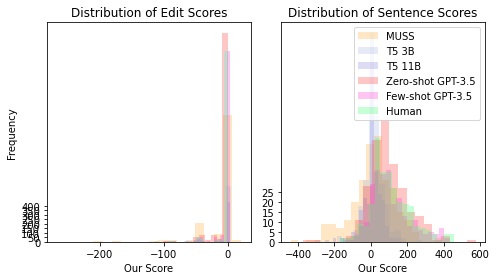

In [3]:
import random

systems = set([x['system'] for x in data])

n_bins = 20
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(7, 4))

for system in [s for s in all_system_labels if s in systems and 'Human' not in s]:
    annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if sent['system'] == system] for x in y], key=lambda x: x['score'])
    axs[0].hist([x['score'] for x in annotations], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])
    axs[1].hist([x['score'] for x in data if x['system'] == system], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])

# Only human annotations
annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if 'Human' in sent['system']] for x in y], key=lambda x: x['score'])
edit_scores, sent_scores = [x['score'] for x in annotations], [x['score'] for x in data if 'Human' in x['system']]
axs[0].hist(random.sample(edit_scores, int(len(edit_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 1 Writing'])
axs[1].hist(random.sample(sent_scores, int(len(sent_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 2 Writing'])

axs[0].set_yticks(np.arange(0, 401, 50))
axs[1].set_yticks(np.arange(0, 26, 5))

axs[0].set_title("Distribution of Edit Scores")
axs[1].set_title("Distribution of Sentence Scores")

axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Our Score")
axs[1].set_xlabel("Our Score")

axs[1].legend()

out_filename = f'img/score-distributions.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()


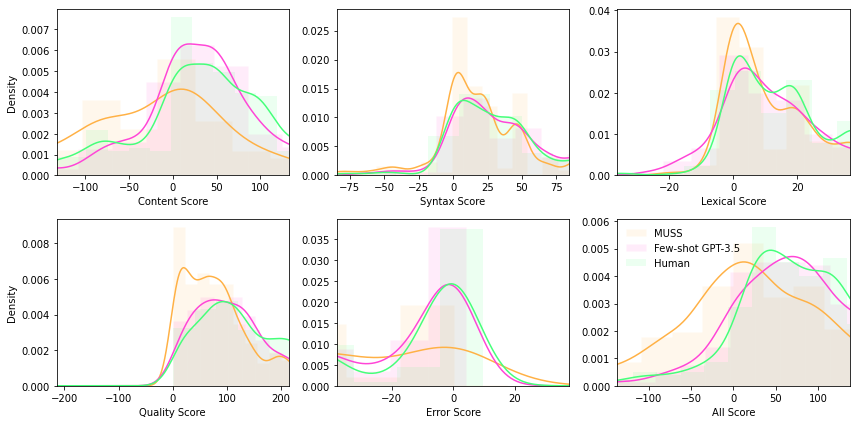

In [4]:
import pandas as pd

fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(12, 6))
n_bins = 20
bw_method = 0.2

chosen_systems = [
    'new-wiki-1/Muss',
    # 'new-wiki-1/T5-3B',
    # 'new-wiki-1/T5-11B',
    # 'new-wiki-1/GPT-3-zero-shot',
    'new-wiki-1/GPT-3-few-shot',
    'new-wiki-1/Human 1 Writing',
    'new-wiki-1/Human 2 Writing'
]
chosen_systems = [s for s in set([x['system'] for x in data]) if s in chosen_systems]

for j, segmentation in enumerate([['content', 'syntax', 'lexical'], ['quality', 'error', 'all']]):
    for i, dim in enumerate(segmentation):
        score_dim = f'{dim}'

        for system in [s for s in all_system_labels if s in chosen_systems and 'Human' not in s]:
            sent_scores = [x['subscores'][score_dim] for x in data if x['system'] == system]
            s = pd.Series(sent_scores)
            axs[j, i] = s.plot.hist(ax=axs[j, i], bins=n_bins, density=True, edgecolor='w', linewidth=0.5, alpha=0.1, label=system_name_mapping[system], color=color_mapping[system])
            axs[j, i] = s.plot.density(ax=axs[j, i], color=color_mapping[system], alpha=1, bw_method=bw_method)
            ax = plt.gca()

        sent_scores = [x['subscores'][score_dim] for x in data if 'Human' in x['system']]
        s = pd.Series(random.sample(sent_scores, int(len(sent_scores)/2)))
        axs[j, i] = s.plot.hist(ax=axs[j, i], bins=n_bins, density=True, linewidth=0.5, alpha=0.1, label='Human', color=color_mapping['new-wiki-1/Human 2 Writing'])
        axs[j, i] = s.plot.density(ax=axs[j, i], color=color_mapping['new-wiki-1/Human 2 Writing'], alpha=1, bw_method=bw_method)

        comp_ratio = 6
        xlim, ylim = axs[j, i].get_xlim(), axs[j, i].get_ylim()
        axs[j, i].set_xlim((-max(xlim)/comp_ratio, max(xlim)/comp_ratio))
        axs[j, i].set_ylim(ylim)

        axs[j, i].set_xlabel(f'{dim.capitalize()} Score')
        axs[j, i].set_ylabel("")

    axs[j, 0].set_ylabel("Density")
axs[1, 2].legend(frameon=False)
out_filename = f'img/performance-distribution.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

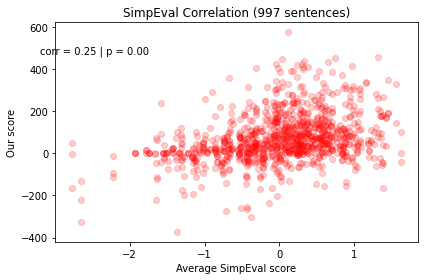

In [5]:
# Graph agreement with SimpEval
data = calculate_sentence_scores(data)
simpeval_agreement(data)

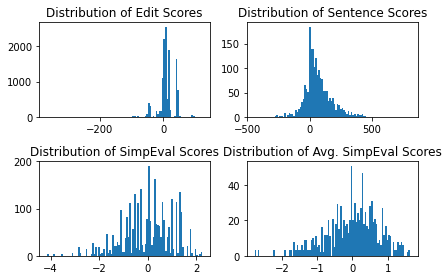

In [6]:
# Show the distribution of edit and sentence scores
score_distribution(data, include_simpeval=True)

In [7]:
# & -- & -- & -- & -- & -- & -- & -- & -- \tabularnewline

# Print the avg. sentence scores for each system
table = ''

subscores = ['lexical', 'syntax', 'content', 'error', 'quality']

std = lambda x: round(np.std(x, ddof=1), 2)

for system in [s for s in all_system_labels if s in systems and 'Human' not in s] + ['aggregated/human']:
    selected = [sent for sent in data if sent["system"] == system]
    if system == 'aggregated/human':
        selected = [sent for sent in data if 'Human' in sent['system']]

    line = f'{system_name_mapping[system]} & '

    for score in subscores:
        selected_scores = [s["subscores"][score] for s in selected]
        line += f'{avg(selected_scores, 2):.2f} & {std(selected_scores):.2f} & '

    selected_scores = [s["score"] for s in selected]
    line += f'{avg(selected_scores, 2):.2f} & {std(selected_scores):.2f}'

    table += f'{line} \\tabularnewline\n'
print(table)

MUSS & 17.15 & 22.41 & 22.44 & 36.09 & -77.30 & 155.56 & -66.64 & 75.59 & 86.36 & 72.66 & 11.49 & 119.41 \tabularnewline
T5 3B & 5.26 & 11.49 & 14.70 & 23.70 & -13.78 & 63.15 & -16.78 & 29.69 & 37.70 & 41.41 & 15.96 & 58.03 \tabularnewline
T5 11B & 3.27 & 8.38 & 9.69 & 20.43 & -18.62 & 57.90 & -16.04 & 31.42 & 24.84 & 33.16 & 4.94 & 51.74 \tabularnewline
Zero-shot GPT-3.5 & 13.11 & 25.80 & 31.62 & 54.72 & 29.70 & 106.27 & -41.70 & 61.94 & 138.84 & 101.42 & 95.53 & 110.56 \tabularnewline
Few-shot GPT-3.5 & 17.34 & 24.81 & 37.88 & 47.20 & 36.83 & 97.27 & -29.48 & 42.36 & 138.45 & 105.78 & 107.26 & 110.81 \tabularnewline
Human & 20.05 & 23.00 & 39.16 & 47.97 & 39.37 & 101.03 & -27.40 & 40.89 & 146.67 & 105.24 & 116.59 & 116.08 \tabularnewline



In [8]:
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import krippendorff

# Calculates sentence-score agreement
def calculate_agreement(data):
    total_agreement = None
    MAX_HIT = max([x['id'] for x in data])+1
    for sent_id in range(0, MAX_HIT):
        sents = [x for x in data if x['id'] == sent_id]
        scores = [sent['score'] for sent in sents]
        if len(scores) == 3:
            if total_agreement is None:
                total_agreement = np.asarray([scores])
            else:
                total_agreement = np.append(total_agreement, np.asarray([scores]), axis=0)
    print(total_agreement.T.shape)
    return krippendorff.alpha(reliability_data=total_agreement[:300, :].T, level_of_measurement='interval')
    # return krippendorff.alpha(value_counts=total_agreement, level_of_measurement='nominal')

In [9]:
param_sets = {
    'current': {
        'good_deletion': 7, # 7
        'good_insertion': 2, # 2
        'good_syntax': 6, # 6
        'good_paraphrase': 2, # 2
        'good_trivial_insertion': 8, # 8
        'content_error': -2, # -2
        'syntax_error': -1, # -1
        'lexical_error': -1.5, # -1.5
        'grammar_error': -1, # -1
        'size_calculation': 'log'
    },
    # 'current_exp': {
    #     'good_deletion': 7, # 7
    #     'good_insertion': 2, # 2
    #     'good_syntax': 6, # 6
    #     'good_paraphrase': 2, # 2
    #     'good_trivial_insertion': 8, # 8
    #     'content_error': -2, # -2
    #     'syntax_error': -1, # -1
    #     'lexical_error': -1.5, # -1.5
    #     'grammar_error': -1, # -1
    #     'size_calculation': 'exp'
    # },
    # 'reported': {
    #     'good_deletion': 10, # 7
    #     'good_insertion': 10, # 2
    #     'good_syntax': 5, # 6
    #     'good_paraphrase': 2, # 2
    #     'good_trivial_insertion': 0, # 8
    #     'content_error': -10, # -2
    #     'syntax_error': -5, # -1
    #     'lexical_error': -2, # -1.5
    #     'grammar_error': -1, # -1
    #     'size_calculation': 'log'
    # },
    'exp': {
        'good_deletion': 10, # 7
        'good_insertion': 10, # 2
        'good_syntax': 5, # 6
        'good_paraphrase': 2, # 2
        'good_trivial_insertion': 0, # 8
        'content_error': -10, # -2
        'syntax_error': -5, # -1
        'lexical_error': -2, # -1.5
        'grammar_error': -1, # -1
        'size_calculation': 'exp'
    },
    'better': {
        'good_deletion': 10, # 7
        'good_insertion': 10, # 2
        'good_syntax': 5, # 6
        'good_paraphrase': 2, # 2
        'good_trivial_insertion': 0, # 8
        'content_error': -10, # -2
        'syntax_error': -5, # -1
        'lexical_error': -2, # -1.5
        'grammar_error': -2, # -1
        'size_calculation': 'exp'
    },
    'experiment': {
        'good_deletion': 10, # 7
        'good_insertion': 10, # 2
        'good_syntax': 5, # 6
        'good_paraphrase': 2, # 2
        'good_trivial_insertion': 0, # 8
        'content_error': -10, # -2
        'syntax_error': -5, # -1
        'lexical_error': -2, # -1.5
        'grammar_error': -2, # -1
        'size_calculation': 'linear'
    },
}
for param in reversed(list(param_sets.keys())):
    print(param)
    out = copy.deepcopy(data)
    for sent in out:
        try:
            sent['score'] = calculate_sentence_score(sent, param_sets[param])
        except Exception as e:
            continue
    print(calculate_agreement(out))

experiment
(3, 518)
0.4752206391218047
better
(3, 518)
0.3927534695789129
exp
(3, 518)
0.4030847639855837
current
(3, 518)
0.39928115966212574


In [10]:
# Attempt to replicate simpeval agreement calculation
total_agreement = None
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [sent['simpeval_scores'] for sent in sents][0]
    if scores is not None and len(scores) == 3:
        if total_agreement is None:
            total_agreement = np.asarray([scores])
        else:
            total_agreement = np.append(total_agreement, np.asarray([scores]), axis=0)

# total_agreement is correct, this should be 0.32
print(total_agreement.T.shape)
krippendorff.alpha(reliability_data=total_agreement.T, level_of_measurement='interval')

(3, 357)


0.3270384070659148

In [11]:
# This is my first time using iPy, so this is a bit clunky...
def series(
    data, 
    average, 
    user,
    good_deletion=default_params['good_deletion'], 
    good_trivial_insertion=default_params['good_trivial_insertion'], 
    good_insertion=default_params['good_insertion'], 
    good_paraphrase=default_params['good_paraphrase'], 
    good_syntax=default_params['good_syntax'], 
    grammar_error=default_params['grammar_error'], 
    content_error=default_params['content_error'], 
    size_calculation=default_params['size_calculation'],
    display_distribution=False
    ):
    params = {
        'good_deletion': good_deletion,
        'good_trivial_insertion': good_trivial_insertion,
        'good_insertion': good_insertion,
        'good_paraphrase': good_paraphrase,
        'good_syntax': good_syntax,
        'grammar_error': grammar_error,
        'content_error': content_error,
        'size_calculation': size_calculation
    }

    selected_data = data
    if user != 'all':
        selected_data = [sent for sent in selected_data if sent['user'] == user]

    selected_data = calculate_sentence_scores(selected_data, params)
    simpeval_agreement(selected_data, average)
    if (display_distribution):
        score_distribution(selected_data)
    return()

interact(
    series, 
    data=[data], 
    good_deletion=(-20,20,0.5), 
    good_trivial_insertion=(-20,20,0.5), 
    good_insertion=(-20,20,0.5), 
    good_paraphrase=(-20,20,0.5), 
    good_syntax=(-20,20,0.5), 
    grammar_error=(-20,20,0.5), 
    content_error=(-20,20,0.5),
    size_calculation=['linear', 'log', 'exp', 'square', 'none'],
    average=[True, False],
    user=['all'] + sorted(list(set([sent['user'] for sent in data]))),
    display_distribution=[True, False]
)

interactive(children=(Dropdown(description='data', options=([{'id': 0, 'original': "The architecture of Winche…

<function __main__.series(data, average, user, good_deletion=10, good_trivial_insertion=0, good_insertion=10, good_paraphrase=2, good_syntax=5, grammar_error=-2, content_error=-10, size_calculation='exp', display_distribution=False)>